# Train Stock Prive Prediction Model

This model predic the open price of the next day of the specific stock.

## Import Packages

In [1]:
import os
import yaml
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## Constants & Settings

In [2]:
CONFIG_FILE = "/workspaces/valuation/config.yaml"

# Load config file
with open(CONFIG_FILE, 'r') as config_file:
    config = yaml.safe_load(config_file)

SEED = config['seed']
TICKER = config['ticker']
LOOK_FORWARD_DAYS = config['test_size_in_days'] # Number of days in the tail.
DATA_SOURCE_FOLDER = os.path.join("/workspaces/valuation/data/staging/stocks", TICKER)

## Read Preprocessed Data

In [3]:
train = pd.read_csv(os.path.join(DATA_SOURCE_FOLDER, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_SOURCE_FOLDER, 'test.csv'))

## Transform Data

In [4]:
train["ds"] = pd.to_datetime(train["ds"])
test["ds"] = pd.to_datetime(test["ds"])

train.drop(columns=["Open", "Adj Close", "Ticker", "Volume", "High", "Low", "Close"], inplace=True)
test.drop(columns=["Open", "Adj Close", "Ticker", "Volume", "High", "Low", "Close"], inplace=True)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

## Model Training

In [5]:
model = Prophet()
#model.add_regressor('High', standardize=False)
#model.add_regressor('Low', standardize=False)
#model.add_regressor('Close', standardize=False)
model.fit(train)

16:37:15 - cmdstanpy - INFO - Chain [1] start processing
16:37:15 - cmdstanpy - INFO - Chain [1] done processing


## Predict

In [9]:
#forecast = model.predict(X_test)
future = model.make_future_dataframe(periods=LOOK_FORWARD_DAYS)
forecast = model.predict(future)
# Merge forecast with test data
forecast = forecast.merge(test.reset_index(drop=True), how='left', on='ds')


## Plot

/home/devuser/.local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/devuser/.local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


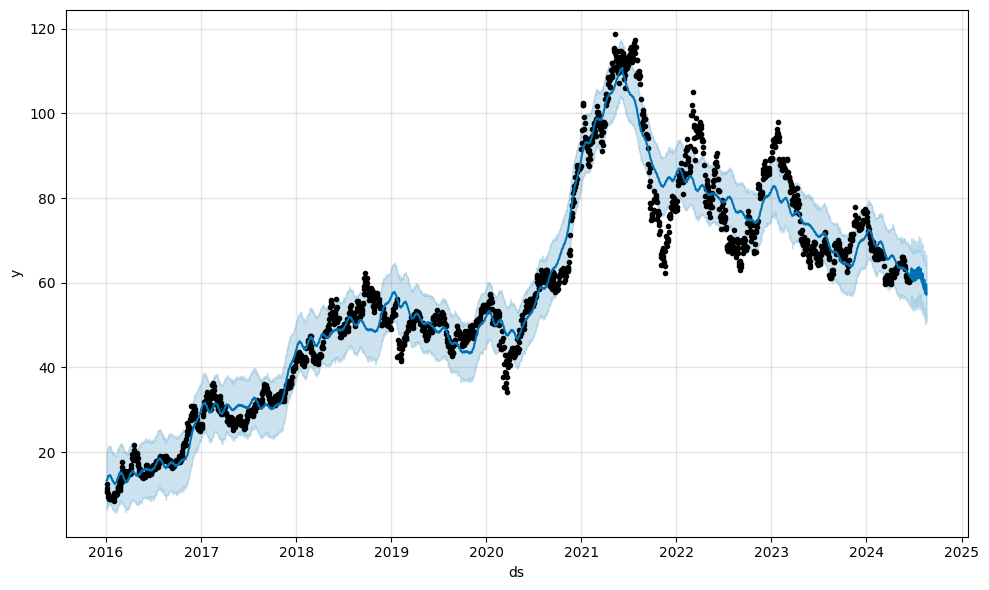

In [12]:
fig1 = model.plot(forecast)

In [13]:
#fig2 = model.plot_components(forecast)

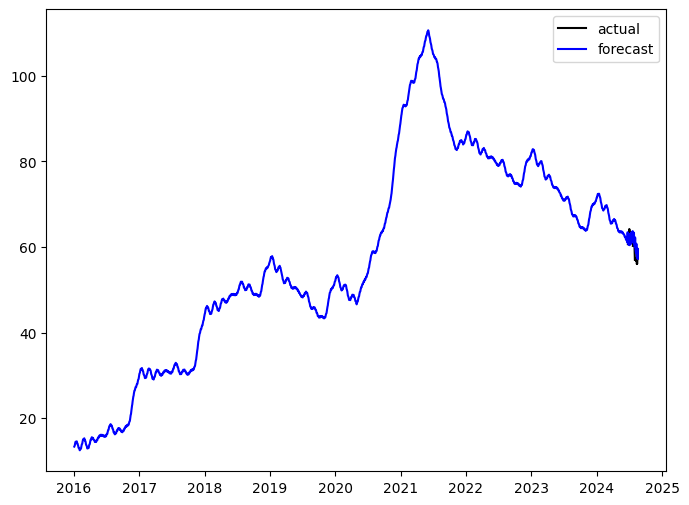

In [16]:
plt.figure(figsize=(8,6))
plt.plot(forecast['ds'],forecast['y'],color='black',label='actual')
plt.plot(forecast['ds'],forecast['yhat'],color='blue',label='forecast')
plt.legend()

## Calculate the Mean Squared Error

In [24]:
mean_squared_error(final_df["yhat"], final_df["y"])

2.834820769505422